In [66]:
import spikeinterface.full as si
import matplotlib.pyplot as plt
import numpy as np
import probeinterface as pi
from pathlib import Path
import os 
import pandas as pd 



basefolder="C:/Users/Freitag/Desktop/myRun_g0"


recording =  si.read_spikeglx(basefolder, stream_id='nidq', load_sync_channel=False)
lfp = si.read_spikeglx(basefolder, stream_id='imec0.lf', load_sync_channel=False)
event =  si.read_spikeglx(basefolder, stream_id='nidq', load_sync_channel=False)
print(recording)

SpikeGLXRecordingExtractor: 9 channels - 11573.700000 Hz - 1 segments - 2,524,051 samples 
                            218.09s (3.63 minutes) - int16 dtype - 43.33 MiB


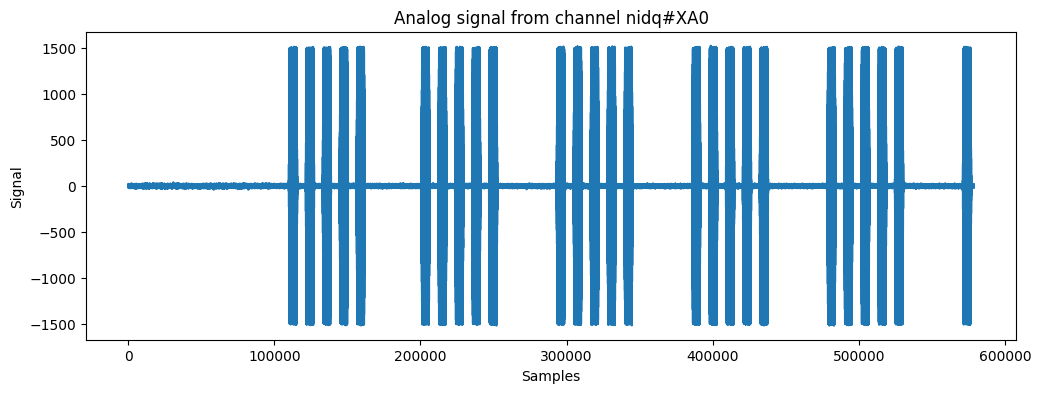

In [51]:

# Get sampling frequency
channel_idx = 0 # or 1, 2, etc., depending on which channel you want
channel_id = event.get_channel_ids()[channel_idx]

# Get trace from that single channel (e.g., first 5 seconds)
sf = event.get_sampling_frequency()
duration = 50  # seconds
trace = event.get_traces(
    start_frame=0,
    end_frame=int(sf * duration),
    channel_ids=[channel_id]
)

# Plot
plt.figure(figsize=(12, 4))
plt.plot(trace[:, 0])
plt.title(f"Analog signal from channel {channel_id}")
plt.xlabel("Samples")
plt.ylabel("Signal")
plt.show()

In [1]:
import numpy as np

ttl_channel_idx = 1
trace = event.get_traces(channel_ids=[channel_ids[ttl_channel_idx]])

# Detect rising edges (assuming TTL goes from 0 to high value)
threshold = 25000  # Adjust based on signal
above_thresh = trace[:, 0] > threshold
rising_edges = np.where(np.diff(above_thresh.astype(int)) == 1)[0]

# Convert to times in seconds
rising_times = rising_edges / sf
print("TTL rising edge times:", rising_times)
print(len(rising_times))
df = pd.DataFrame(rising_times)
df.to_csv('C:/Users/Freitag/Desktop/tt2.csv')


NameError: name 'event' is not defined

Group start times (s): [1.00227239e-02 7.97100322e+00 1.59827022e+01 2.38857064e+01
 3.22974503e+01 4.04929279e+01 4.85570734e+01 5.68204636e+01
 6.49651365e+01 7.29944616e+01 8.14201163e+01 8.94236070e+01
 9.73474343e+01 1.05439747e+02 1.13444966e+02 1.21435150e+02
 1.29769218e+02 1.37910262e+02 1.45913148e+02 1.53916552e+02
 1.61920129e+02 1.69912388e+02 1.78059652e+02 1.86492479e+02
 1.94398075e+02 2.02516136e+02 2.10788166e+02]
27
Wave start times (s): [1.00227239e-02 1.01002272e+00 2.01002272e+00 3.01002272e+00
 4.01002272e+00 7.97100322e+00 8.97100322e+00 9.97100322e+00
 1.09710032e+01 1.19710032e+01 1.59827022e+01 1.69827022e+01
 1.79827022e+01 1.89827022e+01 1.99827022e+01 2.38857064e+01
 2.48857064e+01 2.58857064e+01 2.68857064e+01 2.78857064e+01
 3.22974503e+01 3.32974503e+01 3.42974503e+01 3.52974503e+01
 3.62974503e+01 4.04929279e+01 4.14929279e+01 4.24929279e+01
 4.34929279e+01 4.44929279e+01 4.85570734e+01 4.95570734e+01
 5.05570734e+01 5.15570734e+01 5.25570734e+01 5.682

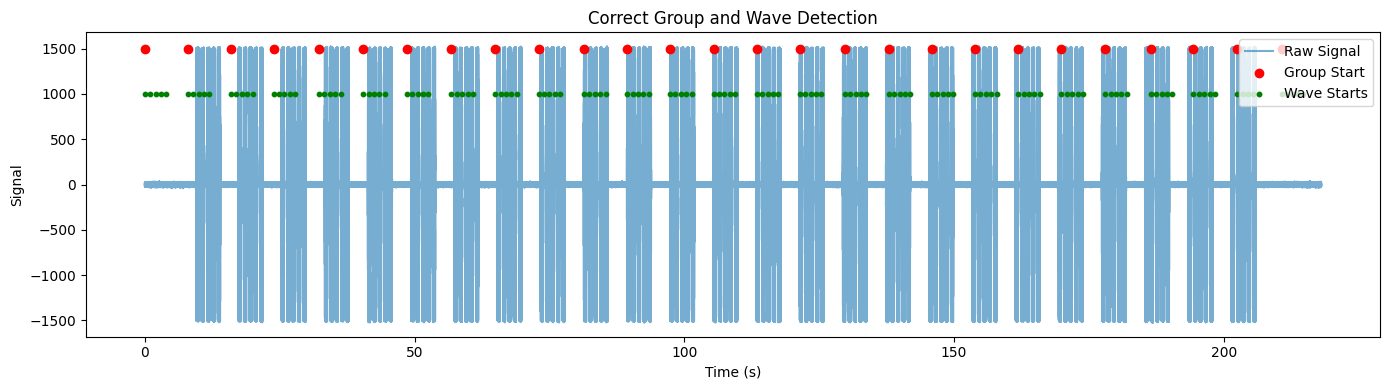

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, convolve, find_peaks
from scipy.signal.windows import gaussian

# Load trace
channel_ids = event.get_channel_ids()
ttl_channel_idx = 0  # or whichever index has your analog signal
channel_id = channel_ids[ttl_channel_idx]

trace = event.get_traces(channel_ids=[channel_id])[:, 0]

sf = event.get_sampling_frequency()
time = np.arange(trace.size) / sf

# Compute smoothed envelope
analytic_signal = hilbert(trace)
envelope = np.abs(analytic_signal)

window_size = int(sf * 0.01)  # 10 ms smoothing
window = gaussian(window_size, std=window_size / 6)
envelope_smooth = convolve(envelope, window, mode='same') / sum(window)

# Find all peaks in envelope (every wave, not just group start)
peaks, _ = find_peaks(envelope_smooth, distance=int(sf * 0.4))  # 400ms min between waves

# Now filter: keep only peaks spaced ≥ 2.5s apart → first wave of each group
min_spacing = int(sf * 7.9)
group_starts = [peaks[0]]
for p in peaks[1:]:
    if p - group_starts[-1] >= min_spacing:
        group_starts.append(p)

group_starts = np.array(group_starts)
group_start_times = group_starts / sf
print("Group start times (s):", group_start_times)
print(len(group_start_times))

# Now compute wave start times from each group
wave_offsets = np.array([0, 1, 2, 3, 4])  # in seconds
wave_times = np.concatenate([
    group_start_times[:, None] + wave_offsets[None, :]
]).flatten()

print("Wave start times (s):", wave_times)

plt.figure(figsize=(14, 4))
plt.plot(time, trace, label='Raw Signal', alpha=0.6)
plt.scatter(group_start_times, [1500]*len(group_start_times), color='red', label='Group Start', zorder=3)
plt.scatter(wave_times, [1000]*len(wave_times), color='green', label='Wave Starts', s=10, zorder=2)
plt.xlabel("Time (s)")
plt.ylabel("Signal")
plt.title("Correct Group and Wave Detection")
plt.legend()
plt.tight_layout()
plt.show()


Using channel ID: nidq#XA0
Sampling frequency: 11573.7 Hz
Loading traces...
Signal loaded. Duration: 1169.22 s, Samples: 2524051
Preprocessing signal...
Applying moving average smoothing with window: 115 samples (10 ms)
Calculating detection threshold...
Estimated noise level (robust std dev): 51.93
Calculated threshold: 5.226e+04
Found 620 potential threshold crossings.
Debouncing events...
Found 125 events after debouncing.
Identifying main and sub-repeat structure...

--- Results ---
Detected 25 main repeats.
Detected 125 total sub-repeats.

Start times of Main Repeats (seconds):
[  9.536017    17.37076302  25.37382168  33.38396537  41.37821094
  49.39621729  57.38476028  65.3930031   73.40573887  81.40430459
  89.40762245  97.41759334 105.4237625  113.42837641 121.42244917
 129.42801351 137.43634274 145.44043823 153.44643459 161.45493662
 169.44684932 177.45733862 185.46359418 193.50726215 201.48785609]

Start times of Sub-Repeats within each Main Repeat (seconds):
  Main Repeat 1 

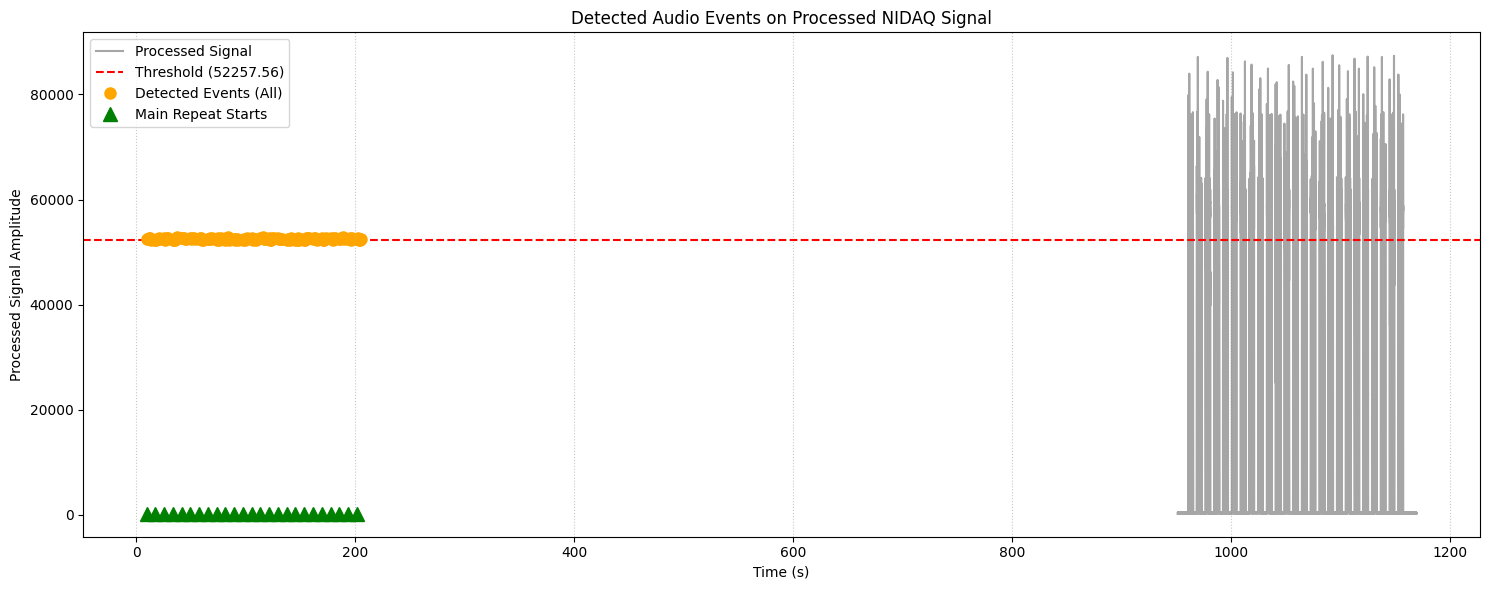

In [78]:
import spikeinterface as si
import spikeinterface.extractors as se
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
# Adjust these based on your signal characteristics and sampling frequency

# Preprocessing
smoothing_window_ms = 10  # Smoothing window in milliseconds (adjust as needed, 0 to disable)

# Detection
threshold_factor = 1000  # How many times above noise level to set threshold (adjust based on SNR)
debounce_interval_ms = 600 # Minimum time between detected events (ms) - should be < 500ms

# Hierarchy Identification
expected_sub_repeat_interval_s = 1 # Expected time between sub-repeats (seconds)
sub_repeat_interval_tolerance_s = 0.090 # Tolerance for sub-repeat interval (seconds)
# Assume gap between main repeats is significantly larger than sub-repeat gap + tolerance
main_repeat_separation_threshold_s = 3# e.g., > 0.8s

# --- Assume 'recording' is your loaded SpikeInterface Recording object ---
# Example loading (replace with your actual loading code)
# recording = se.read_nidq('path/to/your/nidq/recording') 
# Or if already loaded:
# recording = my_loaded_recording_object 

# --- Make sure you have a recording object for this example ---
# Creating a dummy recording for demonstration if you don't have one loaded
try:
    recording # Check if recording exists
except NameError:
    print("Creating a dummy recording for demonstration purposes.")
    sampling_frequency = 30000 # Hz
    traces = np.random.randn(sampling_frequency * 60, 1) * 0.1 # 60 seconds of noise
    # Add some simulated events (replace with your actual data)
    event_times_s = []
    t_start = 5.0
    for main_rep in range(3): # Simulate 3 main repeats instead of 25
        main_start = t_start
        for sub_rep in range(5):
             start_idx = int((main_start + sub_rep * 0.6) * sampling_frequency) # Approx 0.5s silence + 0.1s signal
             end_idx = start_idx + int(0.1 * sampling_frequency) # 100ms signal
             if end_idx < len(traces):
                 traces[start_idx:end_idx, 0] += np.sin(np.linspace(0, 10*np.pi, end_idx-start_idx)) * 1.0 # Add signal burst
             event_times_s.append(main_start + sub_rep * 0.6)
        t_start += 5 * 0.6 + 1.0 # Add longer gap between main repeats
    recording = se.NumpyRecording([traces], sampling_frequency=sampling_frequency)
    print(f"Dummy event times: {event_times_s}")
# --------------------------------------------------------------------

# --- Select the relevant channel ---
# If your NIDAQ signal is on a specific channel, select it.
# Replace 'channel_id_of_interest' with the actual ID if known.
# If it's single channel, channel_ids[0] should work.
if len(recording.get_channel_ids()) > 1:
    # Option 1: Choose a specific channel ID (replace 'your_channel_id')
    # channel_id_to_use = 'your_channel_id' 
    # Option 2: Just use the first channel (common for Aux signals)
    channel_id_to_use = recording.get_channel_ids()[0] 
    print(f"Using channel ID: {channel_id_to_use}")
elif len(recording.get_channel_ids()) == 1:
     channel_id_to_use = recording.get_channel_ids()[0]
     print(f"Using the only available channel ID: {channel_id_to_use}")
else:
    raise ValueError("Recording has no channels!")

# Ensure we work with a single channel recording view
recording_ch = recording.channel_slice([channel_id_to_use])

# --- Get Signal Data ---
fs = recording_ch.get_sampling_frequency()
print(f"Sampling frequency: {fs} Hz")

# Process in chunks if the recording is very long to avoid memory issues
# For simplicity, loading all at once here. Adapt if needed.
print("Loading traces...")
signal = recording_ch.get_traces(segment_index=0, return_scaled=True).flatten()
times = recording_ch.get_times(segment_index=0)
print(f"Signal loaded. Duration: {times[-1]:.2f} s, Samples: {len(signal)}")

# --- 1. Preprocessing ---
print("Preprocessing signal...")
# Rectify (take absolute value)
processed_signal = np.abs(signal)

# Optional: Smoothing (moving average)
window_samples = int(smoothing_window_ms * fs / 1000)
if window_samples > 1:
    print(f"Applying moving average smoothing with window: {window_samples} samples ({smoothing_window_ms} ms)")
    processed_signal = np.convolve(processed_signal, np.ones(window_samples)/window_samples, mode='same')
else:
    print("Smoothing disabled or window too small.")

# --- 2. Thresholding ---
print("Calculating detection threshold...")
# Estimate noise level using Median Absolute Deviation (MAD) for robustness
median_val = np.median(processed_signal)
mad = np.median(np.abs(processed_signal - median_val))

if mad == 0:
    # Handle cases with very little noise or flat signal
    noise_level_est = np.std(processed_signal) 
    print(f"Warning: MAD is zero. Using standard deviation {noise_level_est:.4g} as noise estimate.")
    if noise_level_est == 0:
         raise ValueError("Signal appears to be completely flat. Cannot set threshold.")
else:
    # Convert MAD to equivalent standard deviation for Gaussian noise
    noise_level_est = mad * 1.4826 
    
threshold = median_val + threshold_factor * noise_level_est
print(f"Estimated noise level (robust std dev): {noise_level_est:.4g}")
print(f"Calculated threshold: {threshold:.4g}")

# Find samples where the signal crosses *above* the threshold
above_threshold = processed_signal > threshold
crossings_indices = np.where(np.diff(above_threshold.astype(int)) > 0)[0] + 1 # Add 1 to get the first index *above* threshold

print(f"Found {len(crossings_indices)} potential threshold crossings.")

# --- 3. Debouncing ---
print("Debouncing events...")
debounce_samples = int(debounce_interval_ms * fs / 1000)
if len(crossings_indices) > 0:
    event_indices = [crossings_indices[0]]
    for idx in crossings_indices[1:]:
        if idx - event_indices[-1] >= debounce_samples:
            event_indices.append(idx)
    event_indices = np.array(event_indices)
else:
    event_indices = np.array([])

event_times = event_indices / fs # Convert sample indices to time in seconds
print(f"Found {len(event_times)} events after debouncing.")

# --- 4. Hierarchical Grouping ---
print("Identifying main and sub-repeat structure...")
sub_repeat_start_times = [] # List of arrays, each array contains times for one main repeat
main_repeat_start_times = []

if len(event_times) > 0:
    # First event always starts a main repeat and its first sub-repeat
    main_repeat_start_times.append(event_times[0])
    current_sub_group = [event_times[0]]

    if len(event_times) > 1:
        inter_event_intervals = np.diff(event_times)

        for i, interval in enumerate(inter_event_intervals):
            current_event_time = event_times[i + 1]

            # Check if interval suggests a new main repeat
            if interval > main_repeat_separation_threshold_s:
                # End of the previous main repeat's sub-group
                sub_repeat_start_times.append(np.array(current_sub_group))
                # Start of a new main repeat
                main_repeat_start_times.append(current_event_time)
                current_sub_group = [current_event_time] # Start new sub-group
            # Check if interval matches expected sub-repeat separation
            elif abs(interval - expected_sub_repeat_interval_s) <= sub_repeat_interval_tolerance_s:
                current_sub_group.append(current_event_time)
            else:
                # Interval doesn't fit either pattern
                print(f"Warning: Unexpected interval {interval:.3f}s between event at {event_times[i]:.3f}s and {current_event_time:.3f}s. "
                      f"This event might be noise or indicate timing issues. It won't be grouped.")
                # Decide how to handle - here we just don't add it to the current_sub_group

    # Add the last collected sub-group
    if current_sub_group:
        sub_repeat_start_times.append(np.array(current_sub_group))

# Convert main repeats list to numpy array for consistency
main_repeat_start_times = np.array(main_repeat_start_times)

print("\n--- Results ---")
print(f"Detected {len(main_repeat_start_times)} main repeats.")
print(f"Detected {sum(len(sub_group) for sub_group in sub_repeat_start_times)} total sub-repeats.")

print("\nStart times of Main Repeats (seconds):")
print(main_repeat_start_times)

print("\nStart times of Sub-Repeats within each Main Repeat (seconds):")
for i, sub_group in enumerate(sub_repeat_start_times):
    print(f"  Main Repeat {i+1} (starts at {main_repeat_start_times[i]:.3f}s):")
    print(f"    {sub_group}")

# --- Optional: Verification Plot ---
print("\nGenerating verification plot...")
plt.figure(figsize=(15, 6))
plt.plot(times, processed_signal, label='Processed Signal', alpha=0.7, color='gray')
plt.axhline(threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.2f})')

# Plot detected events (all after debouncing)
plt.plot(event_times, processed_signal[event_indices], 'o', color='orange', markersize=8, label='Detected Events (All)')

# Mark main repeat starts differently
if len(main_repeat_start_times) > 0:
     main_repeat_indices = np.searchsorted(times, main_repeat_start_times)
     # Clip indices to be within bounds
     main_repeat_indices = np.clip(main_repeat_indices, 0, len(processed_signal) - 1)
     plt.plot(main_repeat_start_times, processed_signal[main_repeat_indices], '^', color='green', markersize=10, label='Main Repeat Starts')


plt.title('Detected Audio Events on Processed NIDAQ Signal')
plt.xlabel('Time (s)')
plt.ylabel('Processed Signal Amplitude')
plt.legend()
plt.grid(True, axis='x', linestyle=':', alpha=0.7)
# Optional: Zoom into a specific time range if needed
# plt.xlim(event_times[0] - 1, event_times[0] + 5) 
plt.tight_layout()
plt.show()

In [84]:
def extract_repeat_times(signal_trace, fs, threshold_factor, repeats_per_main_repeat):
    """
    Minimal extraction of main and sub-repeat times based on thresholding
    and interval analysis. Hardcoded parameters for intervals, smoothing, debounce.

    Args:
        signal_trace (np.ndarray): 1D array of the signal.
        fs (float): Sampling frequency in Hz.
        threshold_factor (float): Factor multiplied by noise estimate for threshold.
        repeats_per_main_repeat (int): Expected number of sub-repeats.
                                      (Note: Not used by the current interval-based
                                       grouping logic within this function, but
                                       included per requirements).

    Returns:
        tuple: (main_repeat_start_times, sub_repeat_start_times)
               - main_repeat_start_times (np.ndarray): Start times of main repeats.
               - sub_repeat_start_times (list): List of np.ndarrays, each containing
                                               start times of sub-repeats for one main repeat.
    """
    # --- Hardcoded Parameters ---
    # These values might need tuning depending on the actual signal properties
    smoothing_window_ms = 10.0
    debounce_interval_ms = 100.0  # Min time between detections to count as separate events
    expected_sub_repeat_interval_s = 0.5 # Expected time between starts of sub-repeats
    sub_repeat_interval_tolerance_s = 0.1 # Allowed deviation for sub-repeat interval
    # Time interval clearly indicating a gap *between* main repeats
    main_repeat_separation_threshold_s = 1.0 # Must be > expected_sub + tolerance

    # --- Calculations ---
    # 1. Preprocessing
    processed_sig = np.abs(signal_trace)
    window_samples = int(smoothing_window_ms * fs / 1000.0)
    if window_samples > 1:
        processed_sig = np.convolve(processed_sig, np.ones(window_samples) / window_samples, mode='same')

    # 2. Thresholding (Minimal error handling)
    median_val = np.median(processed_sig)
    mad = np.median(np.abs(processed_sig - median_val))
    noise_est = mad * 1.4826 if mad > 1e-9 else np.std(processed_sig)
    noise_est = max(noise_est, 1e-9) # Prevent zero noise estimate
    threshold = median_val + threshold_factor * noise_est
    crossings_idx = np.where(np.diff((processed_sig > threshold).astype(int)) > 0)[0] + 1

    # 3. Debouncing
    debounce_samples = int(debounce_interval_ms * fs / 1000.0)
    if len(crossings_idx) > 0:
        event_idx = [crossings_idx[0]]
        for idx in crossings_idx[1:]:
            # Keep event if interval since last kept event is sufficient
            if idx - event_idx[-1] >= debounce_samples:
                event_idx.append(idx)
        event_idx = np.array(event_idx)
    else:
        event_idx = np.array([]) # No crossings -> no events
    event_times = event_idx / float(fs) # Convert indices to seconds

    # 4. Hierarchical Grouping (Interval-based)
    sub_repeat_starts_list = []
    main_repeat_starts = []
    if len(event_times) > 0:
        # First event always starts a main repeat and its first sub-repeat
        main_repeat_starts.append(event_times[0])
        current_subs = [event_times[0]]
        if len(event_times) > 1:
            intervals = np.diff(event_times) # Time differences between consecutive events
            for i, interval in enumerate(intervals):
                current_time = event_times[i + 1] # Time of the event ending the interval
                # If interval is large, it signifies a new main repeat
                if interval > main_repeat_separation_threshold_s:
                    # Store the completed sub-group of the previous main repeat
                    sub_repeat_starts_list.append(np.array(current_subs))
                    # Start the new main repeat
                    main_repeat_starts.append(current_time)
                    current_subs = [current_time] # Reset sub-group list for the new main repeat
                # If interval matches expected sub-repeat timing
                elif abs(interval - expected_sub_repeat_interval_s) <= sub_repeat_interval_tolerance_s:
                    # Add this event to the current sub-group
                    current_subs.append(current_time)
                # Else: Interval doesn't match either criterion; event is ignored for grouping
        # Add the last collected sub-group after the loop finishes
        if current_subs:
             sub_repeat_starts_list.append(np.array(current_subs))

    # Ensure output types are consistent (np.array for main, list of np.arrays for subs)
    return np.array(main_repeat_starts), sub_repeat_starts_list